# Home Run Forecasting

# Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import seaborn as sns
from pybaseball import batting_stats
from xgboost import XGBRegressor, plot_importance
from tqdm import tqdm

from sklearn.linear_model import Ridge
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

# allows progress bars for pandas dataframes
tqdm.pandas()

sns.set_style('darkgrid')

# Utility Functions

In [2]:
def next_season(df: pd.DataFrame) -> pd.DataFrame:
    """ 
    Appends next year's number of home runs to each entry 
    """
    df = df.sort_values("Season")
    df["Next_HR"] = df["HR"].shift(-1)
    return df

def player_history(df: pd.DataFrame) -> pd.DataFrame:
    """
    Creates a few extra features that might be helpful. 
    "player_season" just assigns a number to each season that player played.
    "hr_corr" creates correlations between #homeruns and groups of consecutive years.
    "hr_diff" is the difference between this years homeruns and last years.
    """
    df = df.sort_values("Season")
    
    df["player_season"] = range(0, df.shape[0])
    df["hr_corr"] = list(df[["player_season", "HR"]].expanding().corr().loc[(slice(None), "player_season"), "HR"])
    df["hr_corr"].fillna(1, inplace=True)
    
    df["hr_diff"] = df["HR"] / df["HR"].shift(1)
    df["hr_diff"].fillna(1, inplace=True)
    
    df["hr_diff"][df["hr_diff"] == np.inf] = 1
    return df

def group_averages(df: pd.DataFrame) -> pd.DataFrame:
    """
    Divides individual homerun counts by the season average.
    This number tells us if the player hit more homeruns than the average, which 
    might be useful. 
    """
    return df["HR"] / df["HR"].mean()

def walk_forward(data: pd.DataFrame, model, m_features: list, start: int=5, step: int=1) -> pd.DataFrame:
    """ 
    Performs walk-forward validation on the time-series data 
    """
    # The idea is to use 2002, 2003, ... 2006 to predict 2007, 
    # then use all those years plus 2007 to predict 2008 and so on.
    all_preds = []
    years = sorted(data["Season"].unique())
    
    for i in tqdm(range(start, len(years), step)):
        current_year = years[i]
        
        # split seasons into training and validation
        train = data[data["Season"] < current_year]
        valid = data[data["Season"] == current_year]
        
        # fit the model on training data
        model.fit(train[m_features], train["Next_HR"])
        
        # have the model predict the home runs for the validation set
        preds = model.predict(valid[m_features])
        
        # store the predictions
        preds = pd.Series(preds, index=valid.index)
        
        # combine predictions and actuals column-wise to compare
        combined = pd.concat([valid["Next_HR"], preds], axis=1)
        combined.columns = ["Actual", "Prediction"]
        
        # append to all predictions
        all_preds.append(combined)
    
    return pd.concat(all_preds)

# File Paths and Variables

In [3]:
DATA_DIR = "~/Downloads/data_science/baseball_projects/home_run_forecasting/" 
BATTING_FN = "batting_data.csv"

START_SEASON = 2002
END_SEASON = 2022
MIN_AT_BATS = 100

In [4]:
# # use this cell for downloading the data from the internet
# # it does take a little bit to run.
# batting_data = batting_stats(START_SEASON, END_SEASON, qual=MIN_AT_BATS)
# batting_data.to_csv("~/Downloads/data_science/baseball_projects/home_run_forecasting/batting_data.csv", index=False)

# Reading Data

In [5]:
batting_data = pd.read_csv(os.path.join(DATA_DIR, BATTING_FN))

display(batting_data.shape)
batting_data.head()

(9205, 320)

,IDfg,Season,Name,Team,Age,G,AB,PA,H,1B,...,maxEV,HardHit,HardHit%,Events,CStr%,CSW%,xBA,xSLG,xwOBA,L-WAR
0,1109,2002,Barry Bonds,SFG,37,143,403,612,149,70,...,NaN,NaN,NaN,0,0.127,0.191,NaN,NaN,NaN,12.7
1,1109,2004,Barry Bonds,SFG,39,147,373,617,135,60,...,NaN,NaN,NaN,0,0.124,0.164,NaN,NaN,NaN,11.9
2,15640,2022,Aaron Judge,NYY,30,157,570,696,177,87,...,118.4,246.0,0.609,404,0.169,0.287,NaN,NaN,NaN,11.2
3,13611,2018,Mookie Betts,BOS,25,136,520,614,180,96,...,110.6,217.0,0.500,434,0.220,0.270,NaN,NaN,NaN,10.4
4,1109,2003,Barry Bonds,SFG,38,130,390,550,133,65,...,NaN,NaN,NaN,0,0.135,0.223,NaN,NaN,NaN,10.2


# EDA

In [6]:
batting_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9205 entries, 0 to 9204
Columns: 320 entries, IDfg to L-WAR
dtypes: float64(264), int64(52), object(4)
memory usage: 22.5+ MB


In [7]:
batting_data.describe()

,IDfg,Season,Age,G,AB,PA,H,1B,2B,3B,...,maxEV,HardHit,HardHit%,Events,CStr%,CSW%,xBA,xSLG,xwOBA,L-WAR
count,9205.000000,9205.000000,9205.000000,9205.000000,9205.000000,9205.000000,9205.000000,9205.000000,9205.000000,9205.000000,...,3459.000000,7026.000000,3459.000000,9205.000000,9205.000000,9205.000000,0.0,0.0,0.0,9205.000000
mean,6073.321456,2011.968061,28.680608,103.824009,341.474525,382.268441,89.718414,58.682672,17.997501,1.820750,...,109.936340,44.969969,0.356977,94.605866,0.168887,0.266291,NaN,NaN,NaN,1.306290
std,5808.093397,6.033899,4.098724,38.693599,166.119428,186.851052,49.683695,33.204550,10.998938,2.175638,...,3.338332,59.930390,0.083527,147.071711,0.032178,0.029543,NaN,NaN,NaN,1.851884
min,1.000000,2002.000000,19.000000,22.000000,80.000000,100.000000,9.000000,3.000000,0.000000,0.000000,...,97.700000,0.000000,0.053000,0.000000,0.051000,0.137000,NaN,NaN,NaN,-3.400000
25%,1213.000000,2007.000000,26.000000,70.000000,190.000000,211.000000,45.000000,30.000000,9.000000,0.000000,...,107.700000,0.000000,0.306000,0.000000,0.148000,0.247000,NaN,NaN,NaN,0.000000
50%,4146.000000,2012.000000,28.000000,108.000000,330.000000,367.000000,83.000000,54.000000,16.000000,1.000000,...,109.800000,0.000000,0.362000,0.000000,0.169000,0.266000,NaN,NaN,NaN,0.800000
75%,9893.000000,2017.000000,31.000000,139.000000,490.000000,550.000000,131.000000,84.000000,26.000000,3.000000,...,112.200000,78.000000,0.415000,158.000000,0.190000,0.285000,NaN,NaN,NaN,2.200000
max,30116.000000,2022.000000,48.000000,163.000000,716.000000,778.000000,262.000000,225.000000,58.000000,23.000000,...,122.400000,274.000000,0.622000,599.000000,0.299000,0.400000,NaN,NaN,NaN,12.700000


In [8]:
len(batting_data.loc[:, "IDfg"].unique())

1919

These are players that only have one season of data. We're going to remove them later.

In [9]:
player_seasons = batting_data.groupby("IDfg", group_keys=False).size()
player_seasons[player_seasons <= 1].count()

443

## Checking Missing Values

In [10]:
percent_nan = batting_data.isna().sum().sum() / (batting_data.shape[0] * batting_data.shape[1])
percent_nan *= 100
print("Percent of NaN values in the entire csv: {0:.2f}%".format(percent_nan))

Percent of NaN values in the entire csv: 24.99%


These are all the columns where at least 60% of the values are NaN. Most of these are stats that weren't kept track of consistently until later on. <br>
We're gonna take these out later since imputing values wouldn't be very helpful. 

In [11]:
column_wise_nan = batting_data.isna().sum() / batting_data.count()
bad_cols = [col for col, val in zip(column_wise_nan.index, column_wise_nan.values) if val >= 0.60]

print(f"Number of bad columns: {len(bad_cols)}\n")
print(bad_cols)

Number of bad columns: 69

['KN%', 'KNv', 'PO%', 'wKN', 'wKN/C', 'FT% (sc)', 'FO% (sc)', 'EP% (sc)', 'SC% (sc)', 'KN% (sc)', 'UN% (sc)', 'vFT (sc)', 'vFO (sc)', 'vEP (sc)', 'vSC (sc)', 'vKN (sc)', 'FT-X (sc)', 'FO-X (sc)', 'EP-X (sc)', 'SC-X (sc)', 'KN-X (sc)', 'FT-Z (sc)', 'FO-Z (sc)', 'EP-Z (sc)', 'SC-Z (sc)', 'KN-Z (sc)', 'wFT (sc)', 'wFO (sc)', 'wEP (sc)', 'wSC (sc)', 'wKN (sc)', 'wFT/C (sc)', 'wFO/C (sc)', 'wEP/C (sc)', 'wSC/C (sc)', 'wKN/C (sc)', 'CS% (pi)', 'KN% (pi)', 'SB% (pi)', 'XX% (pi)', 'vCS (pi)', 'vKN (pi)', 'vSB (pi)', 'vXX (pi)', 'CS-X (pi)', 'KN-X (pi)', 'SB-X (pi)', 'XX-X (pi)', 'CS-Z (pi)', 'KN-Z (pi)', 'SB-Z (pi)', 'XX-Z (pi)', 'wCS (pi)', 'wKN (pi)', 'wSB (pi)', 'wXX (pi)', 'wCS/C (pi)', 'wKN/C (pi)', 'wSB/C (pi)', 'wXX/C (pi)', 'FRM', 'EV', 'LA', 'Barrel%', 'maxEV', 'HardHit%', 'xBA', 'xSLG', 'xwOBA']


Next, we're checking the adjusted stats. The stats with a "+" in them indicate a statistic adjusted for external factors such as fields. \
They pretty much measure the same thing as their non-plus counterparts so we can remove the other ones.

In [12]:
# taking a look at adjusted statistics
adj_cols = [col for col in batting_data.columns if "+" in col]
temp = [col.replace("+", "") for col in adj_cols] + ["HR/FB"]
non_adj_cols = list(batting_data.loc[:, batting_data.columns.isin(temp)].columns)

mapper = {k: k for k in non_adj_cols}

for x in adj_cols:
    temp = x.replace("+", "")
    if temp in mapper:
        print(f"{x:<10} {mapper[temp]:>5}")
    else:
        print(f"{x:<10}")

wRC+         wRC
+WPA         WPA
AVG+         AVG
BB%+         BB%
K%+           K%
OBP+         OBP
SLG+         SLG
ISO+         ISO
BABIP+     BABIP
LD+%         LD%
GB%+         GB%
FB%+         FB%
HR/FB%+   
Pull%+     Pull%
Cent%+     Cent%
Oppo%+     Oppo%
Soft%+     Soft%
Med%+       Med%
Hard%+     Hard%


Because the pandemic screwed up the 2020 season, I'm going to remove it from the data. 

In [13]:
batting_data = batting_data[batting_data["Season"] != 2020]

The line below sets up our target variable for each row in the data.

In [14]:
batting_data = batting_data.groupby("IDfg", group_keys=False).progress_apply(next_season)

100%|████████████████████████████████████████████████████████████████████████████| 1919/1919 [00:01<00:00, 1327.20it/s]


## Cleaning Data

This is removing any player that only has one season of data.

In [15]:
batting_data = batting_data.groupby("IDfg", group_keys=False).filter(lambda x: x.shape[0] > 1)

Dropping out the bad columns we saw earlier. I'm also going to keep in the entries that don't have a number <br>
for "Next_HR" in 2022 so that I can perform all the manipulations on one dataframe. I'll use those values for forecasting later.

In [16]:
# dropping columns with tons of missing data
batting_data = batting_data.drop(bad_cols, axis=1)

# dropping rows with NaN homeruns and the 2022 season
bad_rows = batting_data[(batting_data["Next_HR"].isna()) & (batting_data["Season"] != 2022)].index
batting_data = batting_data.drop(bad_rows, axis=0)

# dropping the non-adjusted versions of the columns
batting_data = batting_data.drop(columns=non_adj_cols, axis=1)
batting_data.shape

(7343, 233)

Filling in any leftover missing values with the median values of their respective columns. We're gonna ignore the NaN values in the "Next_HR" column for now.

In [17]:
# filling in NaN values with median (median values had better results than mean)
for col in batting_data.columns:
    if col == "Next_HR":
        pass
    if batting_data[col].dtype == int or batting_data[col].dtype == float:
        batting_data[col].fillna(batting_data[col].median(), inplace=True)
    else:
        # if the object types have NaN
        batting_data[col].fillna("None", inplace=True)
        
batting_data.loc[:, batting_data.columns != "Next_HR"].isna().sum().sum()

0

In [18]:
batting_data.dtypes[batting_data.dtypes == "object"]

Name       object
Team       object
Dol        object
Age Rng    object
dtype: object

Now we're gonna check the object datatypes.

Basically, this column is a calculated dollar amount assigned to the player. We can just throw this out.

In [19]:
batting_data["Dol"]

7506     ($0.8)
7841     ($1.2)
4117       $5.5
2639      $11.2
1034      $14.6
         ...   
8050     ($4.1)
7106     ($1.1)
9070    ($10.4)
5569       $3.9
1076      $29.3
Name: Dol, Length: 7343, dtype: object

This age range column is weird in that it shows the age range of the player for just that season. So, it really doesn't provide anything more than the "Age" column does.

In [20]:
batting_data["Age Rng"]

7506    25 - 25
7841    26 - 26
4117    28 - 28
2639    29 - 29
1034    30 - 30
         ...   
8050    24 - 24
7106    29 - 29
9070    30 - 30
5569    25 - 25
1076    26 - 26
Name: Age Rng, Length: 7343, dtype: object

In [21]:
del batting_data["Dol"]
del batting_data["Age Rng"]

Next we're gonna encode the teams.

In [22]:
batting_data["team_enc"] = batting_data["Team"].astype("category").cat.codes

## Distributions and Plots

### Total Home Runs Per Year

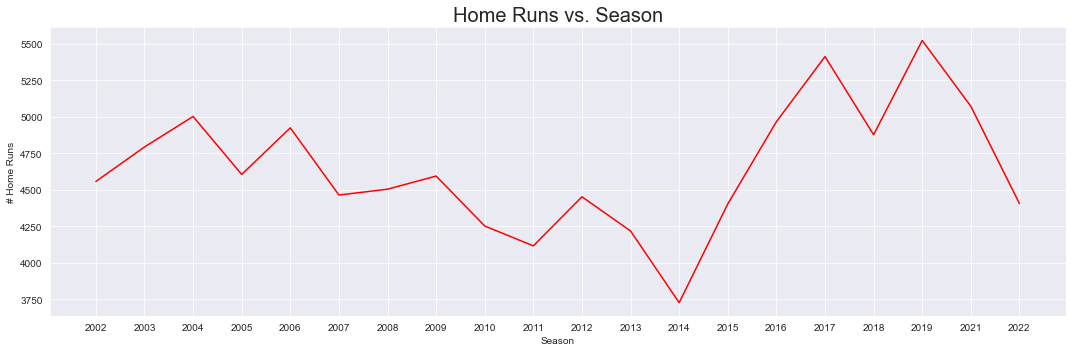

In [23]:
hr_years = batting_data.groupby("Season")["HR"].sum()

plt.figure(figsize=(15, 5))
plt.ylabel("# Home Runs")
plt.xlabel("Season")
plt.title("Home Runs vs. Season", fontsize=20)
plt.plot(hr_years.index.astype(str), hr_years.values, color='r')
plt.tight_layout()

For this dataset, the number of home runs is on a slight downward trend from 2002 to 2014. These numbers definitely don't reflect the <br> 
true season totals because I've only included players with 100 plate appearances, and I removed a lot of entries that didn't have a number <br>
for next season's home runs.

### Home Run Frequencies

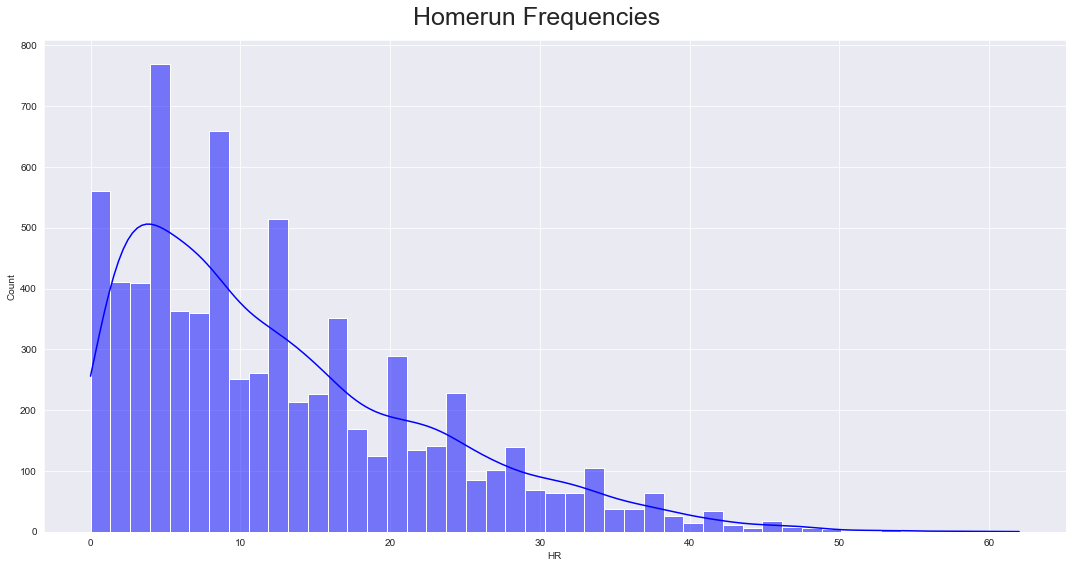

In [24]:
fig = plt.figure(figsize=(15, 8))

sns.histplot(data=batting_data, x="HR", kde=True, color='blue')
fig.suptitle("Homerun Frequencies", fontsize=25)
plt.tight_layout()

A majority of players hit less than 20 home runs per season. There are a few star outliers that hit 50 and above. 
We can check out those players below.

In [25]:
batting_data[batting_data["HR"] > 50][["Name", "Season", "Team", "HR"]]

,Name,Season,Team,HR
47,Andruw Jones,2005,ATL,51
72,Jim Thome,2002,CLE,52
362,David Ortiz,2006,BOS,54
8,Alex Rodriguez,2002,TEX,57
10,Alex Rodriguez,2007,NYY,54
155,Jose Bautista,2010,TOR,54
242,Ryan Howard,2006,PHI,58
118,Giancarlo Stanton,2017,MIA,59
92,Chris Davis,2013,BAL,53
19,Aaron Judge,2017,NYY,52


There are definitely a couple of Hall of Famers on that list. 

## Correlations
We're gonna check if any the features are significanly correlated with next season's home runs.

In [26]:
use_cols = batting_data.columns[~batting_data.columns.isin(["IDfg", "Season", "Name", "Team"])]
correlations = batting_data[~batting_data["Next_HR"].isna()][use_cols].corr()["Next_HR"][:]

In [27]:
sorted_corrs = correlations.sort_values()

In [28]:
print(sorted_corrs[:25])

Med%+             -0.391694
-WPA              -0.378384
SH                -0.289537
GB/FB             -0.289135
Soft%+            -0.282617
GB%+              -0.281438
Pos               -0.279170
BU                -0.260383
Zone% (pi)        -0.251440
Zone% (sc)        -0.247932
FB% (Pitch)       -0.235852
Contact%          -0.227815
CStr%             -0.223223
Z-Contact%        -0.214485
Oppo%+            -0.210875
PH                -0.205029
Def               -0.191234
Zone%             -0.188106
Contact% (sc)     -0.185504
Contact% (pi)     -0.185397
F-Strike%         -0.182688
O-Contact%        -0.179687
BUH               -0.179002
Z-Contact% (sc)   -0.174932
Z-Contact% (pi)   -0.174231
Name: Next_HR, dtype: float64


In [29]:
print(sorted_corrs[sorted_corrs.shape[0]-26:-1])

Rep        0.407174
2B         0.409935
Pitches    0.426356
FB         0.441992
Balls      0.450567
SO         0.452796
BB         0.453338
wRC+       0.459532
R          0.459863
wOBA       0.461713
REW        0.462105
RE24       0.466116
Off        0.466762
wFB        0.469749
+WPA       0.479930
WPA/LI     0.489950
Bat        0.491311
OPS        0.491432
wRAA       0.507710
HR/FB%+    0.508361
Hard%+     0.523343
SLG+       0.525170
ISO+       0.558331
RBI        0.562842
HR         0.636610
Name: Next_HR, dtype: float64


In [30]:
neg_features = sorted_corrs.index[:8]
pos_features = sorted_corrs.index[sorted_corrs.shape[0]-9:-1]

We can even view some of these in scatter plots.

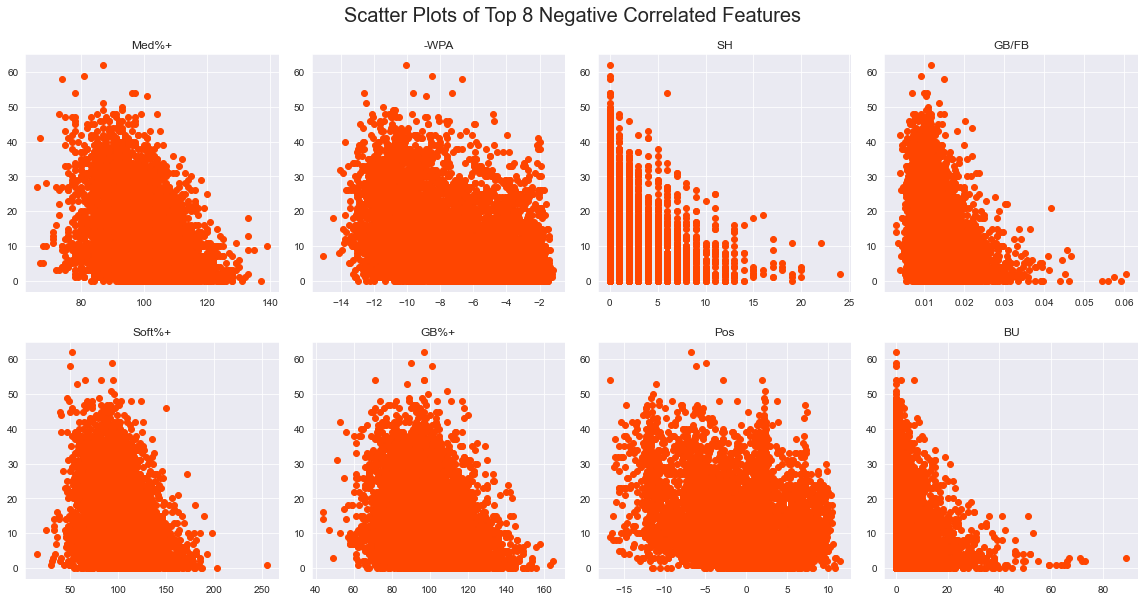

In [31]:
_, axs = plt.subplots(2, 4, figsize=(16, 8))
for col, ax in zip(neg_features, axs.ravel()):
    next_hr = batting_data["Next_HR"].values
    col_data = batting_data[col].values
    ax.scatter(col_data, next_hr, color='orangered')
    ax.set_title(col)
plt.tight_layout(h_pad=2)
plt.suptitle("Scatter Plots of Top 8 Negative Correlated Features", fontsize=20, y=1.04)
plt.show()

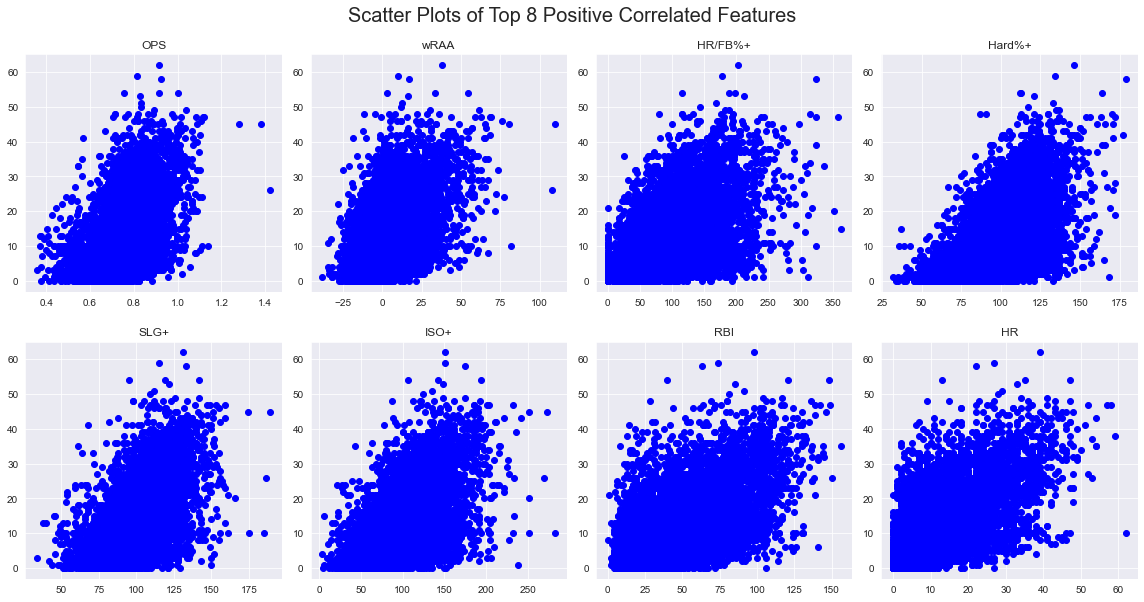

In [32]:
_, axs = plt.subplots(2, 4, figsize=(16, 8))
for col, ax in zip(pos_features, axs.ravel()):
    next_hr = batting_data["Next_HR"].values
    col_data = batting_data[col].values
    ax.scatter(col_data, next_hr, color='blue')
    ax.set_title(col)
plt.tight_layout(h_pad=2)
plt.suptitle("Scatter Plots of Top 8 Positive Correlated Features", fontsize=20, y=1.04)
plt.show()

The heatmap below of the first 10 features suggests we have multicollinearity. \
It's highly likely that there are more variables that are correlated with each other. 

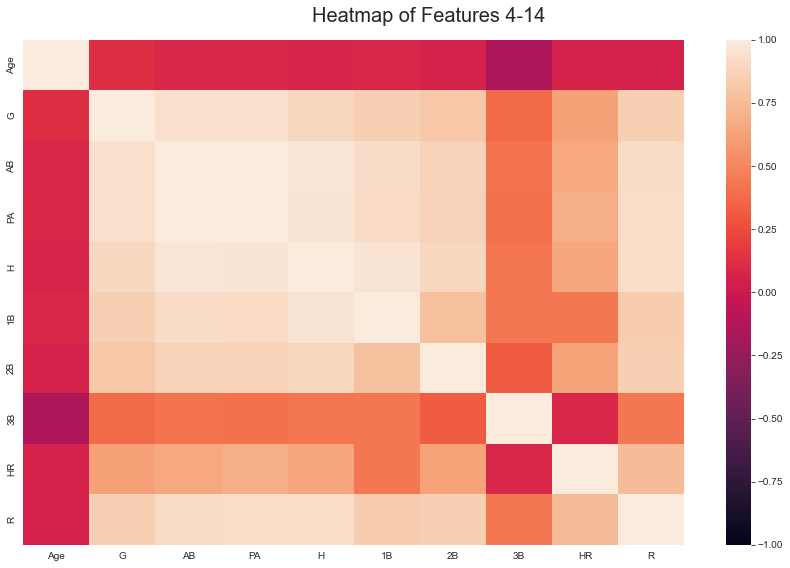

In [33]:
fig = plt.figure(figsize=(12, 8))
sample_corrs = batting_data.iloc[:, 4:14].corr()
sns.heatmap(data=sample_corrs, vmin=-1, vmax=1)
plt.suptitle("Heatmap of Features 4-14", fontsize=20)
plt.tight_layout()

In [34]:
batting_data = batting_data.groupby("IDfg", group_keys=False).progress_apply(player_history)
batting_data["hr_season"] = batting_data.groupby("Season", group_keys=False).progress_apply(group_averages)

100%|████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 2006.75it/s]


With the line above, I created a couple of new features I thought might be useful. They basically give information about the number of home runs the year before. 

# Modeling

In [35]:
params = {
    "tree_method": "gpu_hist",
    "n_estimators": 50,
    "eval_metric": mean_squared_error,
    "eta": 0.3,
    "max_depth": 3,
    "gamma": 15,
    "colsample_bytree": 0.3
}

# notes for parameters:

# tree_method - is set so that XGBoost uses the gpu
# n_estimators - number of trees created, larger values lead to bigger MSE. [50-100] should be good.
# eval_metric - metric to evaluate performance, I used mean squared error.
# eta - essentially the learning rate for xgboost. 0.3 worked the best.
# max_depth - the maximum depth a tree reaches. Lower values like 3 worked the best and prevent overfitting. 
# gamma - "the complexity cost of adding another leaf" works well when we have shallow trees. Higher values give lower MSE.
# colsample_bytree - the number of columns sampled when creating a tree. 0.3 is the best. Lower or higher gives worse results.

In [36]:
xgb_model = XGBRegressor(**params)
split = TimeSeriesSplit(n_splits=3)

In [37]:
removed_columns = ["Next_HR", "Name", "Team", "IDfg", "Season"]
selected_columns = batting_data.columns[~batting_data.columns.isin(removed_columns)]

In [38]:
# getting a list of the main features

#good_features = list(sorted_corrs[:25].index) + list(sorted_corrs[sorted_corrs.shape[0]-26:-1].index) + ["hr_corr", "hr_season", "hr_corr"]
# main_features = list(selected_columns[selected_columns.isin(good_features)])
main_features = list(selected_columns)
main_features[:20]

['Age',
 'G',
 'AB',
 'PA',
 'H',
 '1B',
 '2B',
 '3B',
 'HR',
 'R',
 'RBI',
 'BB',
 'IBB',
 'SO',
 'HBP',
 'SF',
 'SH',
 'GDP',
 'SB',
 'CS']

## Training

In [39]:
good_data = batting_data[~batting_data["Next_HR"].isna()]

In [40]:
predictions = walk_forward(good_data, xgb_model, main_features)

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:04<00:00,  3.13it/s]


# Evaluation

In [41]:
predictions

,Actual,Prediction
2639,3.0,3.438311
3469,15.0,14.469218
5638,1.0,1.099839
4897,2.0,2.586560
5017,4.0,2.185248
...,...,...
4540,10.0,15.593005
5282,10.0,10.227806
8050,10.0,17.497301
9070,10.0,7.952501


In [42]:
mse = mean_squared_error(predictions["Actual"], predictions["Prediction"])
print(f"MSE: {mse}")

MSE: 57.54080277963238


The mean squared error is the average of the square of all the errors. Ideally, this number would be smaller. <br>
This number went from ~65 to the current one after a lot of XGBoost tuning. 

In [43]:
print("Next_HR std:    {}".format(batting_data["Next_HR"].std()))
print(f"Square Root MSE: {np.sqrt(mse)}")

Next_HR std:    9.872584952668396
Square Root MSE: 7.585565422539863


This is something I like to look at. Generally, if the square root of the mean squared error is less than the standard deviation, <br>
the model does a bit better than guessing.

In [44]:
r2 = r2_score(predictions["Actual"], predictions["Prediction"])
print(f"R\u00b2 value: {r2}")

R² value: 0.3816136908625992


This is the R<sup>2</sup> value for the model. It basically measures how well the regression line fit the data. <br>
We want this number to be as close to 1 as possible. 0.38 is kinda decent. Ideally, it would be higher, but it does indicate that some of the <br>
variance is explained in our model.

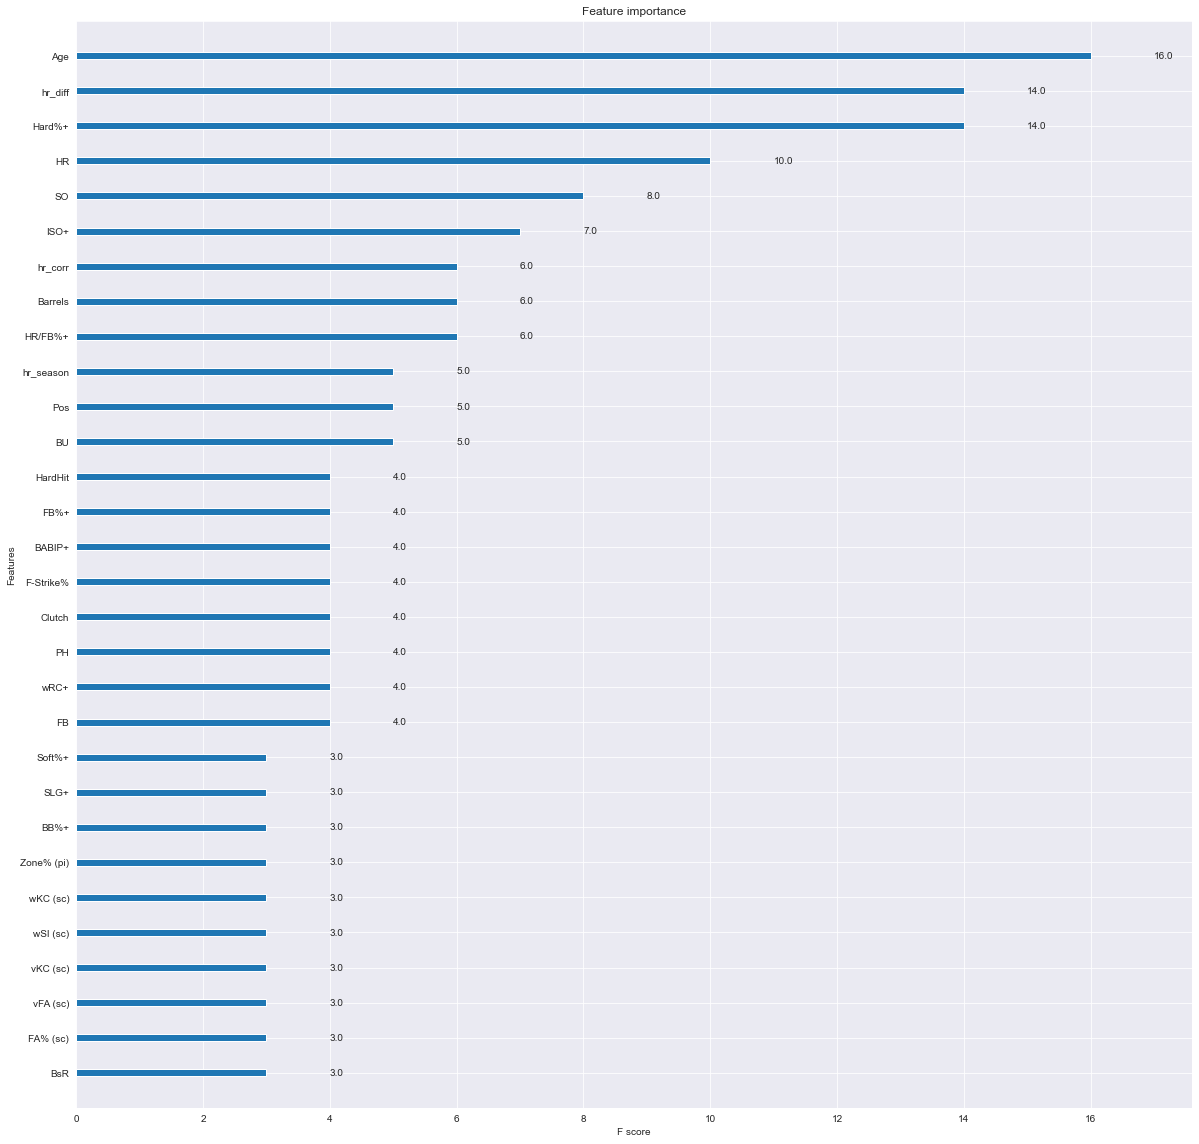

In [45]:
plt.rcParams['figure.figsize'] = [20, 20]
plot_importance(xgb_model, max_num_features=30)
plt.show()

One advantage of XGBoost is that we still retain a little bit of explanatory power, which is why I just used the singular model. <br>
Age ends up being the most important factor in determing next year's home runs, which kinda makes sense. 

# Forecasting
Now, we'll predict home runs for the 2023 season.

In [46]:
players_2022 = batting_data[batting_data["Season"] == 2022]
players_2022

,IDfg,Season,Name,Team,Age,G,AB,PA,H,1B,...,Events,CStr%,CSW%,L-WAR,Next_HR,team_enc,player_season,hr_corr,hr_diff,hr_season
2800,1177,2022,Albert Pujols,STL,42,109,307,351,83,45,...,258,0.165,0.258,1.9,10.0,29,19,-0.747612,1.411765,1.999092
9113,1744,2022,Miguel Cabrera,DET,39,112,397,433,101,86,...,301,0.149,0.270,-1.4,10.0,11,18,-0.492298,0.333333,0.416478
3047,2136,2022,David Peralta,- - -,34,134,439,490,110,65,...,331,0.149,0.273,1.0,10.0,0,7,0.084704,1.500000,0.999546
4314,2396,2022,Carlos Santana,- - -,36,131,431,506,87,50,...,345,0.177,0.260,1.0,10.0,0,11,0.339675,1.000000,1.582615
8600,2434,2022,Nelson Cruz,WSN,41,124,448,507,105,79,...,335,0.127,0.277,-0.9,10.0,34,15,0.538087,0.312500,0.832955
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4540,24618,2022,Ryan Jeffers,MIN,25,67,212,236,44,26,...,151,0.179,0.273,0.9,10.0,19,1,-1.000000,0.500000,0.583069
5282,24655,2022,Owen Miller,CLE,25,130,424,472,103,70,...,340,0.188,0.266,-0.1,10.0,9,1,1.000000,1.500000,0.499773
8050,26197,2022,Andrew Vaughn,CHW,24,134,510,555,138,92,...,419,0.201,0.291,0.4,10.0,7,1,1.000000,1.133333,1.416024
9070,27459,2022,Yoshi Tsutsugo,PIT,30,50,170,193,29,23,...,124,0.181,0.267,-1.5,10.0,25,1,-1.000000,0.250000,0.166591


## MLB Leaderboard

In [47]:
mlb_preds = xgb_model.predict(players_2022[main_features])
mlb_preds = pd.Series(mlb_preds, index=players_2022.index)

# have to round because it predicts a decimal number of homeruns
mlb_preds = mlb_preds.apply(round)
mlb_leaderboard = pd.concat([players_2022["Name"], mlb_preds], axis=1)
mlb_leaderboard.columns = ["Player", "HR_Pred"]

mlb_leaderboard = mlb_leaderboard.sort_values("HR_Pred", ascending=False)

In [48]:
mlb_leaderboard.iloc[:10].to_csv("mlb_homerun_leaderboard.csv", index=False)
mlb_leaderboard.head(10)

,Player,HR_Pred
330,Austin Riley,35
963,Shohei Ohtani,35
1861,Kyle Schwarber,34
1666,Vladimir Guerrero Jr.,34
2,Aaron Judge,33
853,Pete Alonso,32
213,Mike Trout,31
681,Carlos Correa,29
3206,Ryan Mountcastle,28
1448,Matt Olson,28


Honestly, it's not a bad list. Pretty much all of these guys are power hitters, and I think nobody would be surprised if Shohei or Riley were the home run leader next season. <br>
I do think it falls short in the predicted number of home runs. Generally, I think this would be a bit higher for the leaders, but
it is hard for the model to get the outliers correct.

# Future Work

1. Dealing with Outliers / Model Structure
        Ideally, the goal of the model would be to correctly predict the outliers (players who are going to hit a large number of homeruns).
        As it is, the model barely does a decent job of predicting the majority correctly. One thing that might help would be to structure 
        the problem as a classification problem and classify whether or not a player will hit a small, normal, or large number of homeruns. 
        Then we can have separate models for predicting the actual numbers within those subclasses. 


2. Multicollinearity
        Another problem that's tough to deal with is the multicollinearity issue. XGBoost, in a way, handles this for us since it is a 
        tree based algorithm. However, it would still be really beneficial to do some more sophisticated feature reduction/selection. 


3. Explainable or Not
        One of the focuses for this model was to retain some type of explainability so that we can have a reason as to why we think 
        some of these players are going to do well. We can simply throw this idea out the window if we want to focus on pure performance. 
        This opens up PCA, ensembling, and possibly neural networks (that'll probably be overkill, but it's still an idea). 
        
        